#### Importing Libraries


In [1]:
#importing necessary libraries
import cv2
import os
import joblib
import skimage
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array
from keras import layers, initializers, optimizers, regularizers

# Setting a random seed
np.random.seed(180)

plt.style.use("ggplot")

#### Loading the Data Set

In [2]:
# Reading train and test dataset
train = pd.read_csv("sign_mnist_train.csv")
test = pd.read_csv("sign_mnist_test.csv")

# printing first five rows of the train data
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [3]:
# a class to decribe the dataset
class Describer:

    #initialize an object
    def __init__(self, df):
        self.df = df

    #checking the shape of the data
    def shape(self, name):
        return print(f"The {name} dataset has {self.df.shape[0]} entries and {self.df.shape[1]} columns")

In [4]:
#Viewing the shape of the train dataset
data = Describer(train)
data.shape("train")

The train dataset has 27455 entries and 785 columns


In [5]:
#Viewing the shape of the test dataset
data = Describer(test)
data.shape("test")

The test dataset has 7172 entries and 785 columns


In [6]:
# Displaying the column names
train.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [7]:
# reading the collected raw images
train_generator = ImageDataGenerator().flow_from_directory("Images", target_size=(28,28),
                                                           batch_size=3000)

Found 2445 images belonging to 24 classes.


In [8]:
#Getting all images and labels
train_images, train_labels = next(train_generator)

In [9]:
#Flattening images into lists of pixels
images_list = []
for img_array in train_images:
    gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    gray = np.expand_dims(gray, 2)
    images_list.append(gray.reshape(-1, 784).flatten().tolist())

In [10]:
#converting the images to a DataFrame
raw_img_df = pd.DataFrame(images_list)
raw_img_df.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,255.0,255.0,254.41301,255.0,146.244995,147.875000,147.277008,152.337006,151.109009,154.119995,...,126.717995,127.276993,131.091995,132.234009,132.244995,254.472992,255.000000,255.0,255.0,255.0
1,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,254.885986,150.245010,...,125.244995,254.472992,254.402008,255.000000,255.000000,255.000000,255.000000,255.0,255.0,255.0
2,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,254.885986,150.234009,...,130.000000,254.000000,254.885986,255.000000,255.000000,255.000000,255.000000,255.0,255.0,255.0
3,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,254.413010,255.000000,255.000000,255.000000,254.885986,255.0,255.0,255.0
4,255.0,255.0,255.00000,255.0,254.885986,142.472992,143.244995,144.233994,146.875000,147.875000,...,119.875000,118.234001,122.234001,118.875008,253.874985,255.000000,254.000000,255.0,255.0,255.0


In [11]:
# Generating the labels
train_labels = pd.Series([np.argmax(label)
                           for label in train_labels])

In [12]:
# Concatenating the labels and the raw picture dataframe
raw_df = pd.concat([train_labels, raw_img_df], axis=1)
raw_df.columns = train.columns

#Displaying the first 5 rows of the raw images dataframe
raw_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,11,255.0,255.0,254.41301,255.0,146.244995,147.875000,147.277008,152.337006,151.109009,...,126.717995,127.276993,131.091995,132.234009,132.244995,254.472992,255.000000,255.0,255.0,255.0
1,3,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,254.885986,...,125.244995,254.472992,254.402008,255.000000,255.000000,255.000000,255.000000,255.0,255.0,255.0
2,5,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,254.885986,...,130.000000,254.000000,254.885986,255.000000,255.000000,255.000000,255.000000,255.0,255.0,255.0
3,14,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,254.413010,255.000000,255.000000,255.000000,254.885986,255.0,255.0,255.0
4,21,255.0,255.0,255.00000,255.0,254.885986,142.472992,143.244995,144.233994,146.875000,...,119.875000,118.234001,122.234001,118.875008,253.874985,255.000000,254.000000,255.0,255.0,255.0


In [13]:
#splitting the raw df to train and test dataframes
train_df, test_df = train_test_split(raw_df, test_size=0.1, random_state=180)

#### Combining Datasets
The kaggle dataset labels are from 0-24 with 9 and 25 missing which represent the j and z letters that have been excluded but the raw dataset labels are from 0-23. For the two datasets to be merged, the labels should be similar.

In [14]:
# mapping the labels into correct labels
mapping_dict = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 10: 9, 11: 10,
                12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19,
                21: 20, 22: 21, 23: 22, 24: 23}

train["label"] = train["label"].map(mapping_dict)
test["label"] = test["label"].map(mapping_dict)

In [15]:
# Concatenating the collected images and the train dataset
train = pd.concat([train, train_df])
train.reset_index(drop=True, inplace=True)

# Displaying the first five rows
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107.0,118.0,127.0,134.0,139.0,143.0,146.0,150.0,153.0,...,207.0,207.0,207.0,207.0,206.0,206.0,206.0,204.0,203.0,202.0
1,6,155.0,157.0,156.0,156.0,156.0,157.0,156.0,158.0,158.0,...,69.0,149.0,128.0,87.0,94.0,163.0,175.0,103.0,135.0,149.0
2,2,187.0,188.0,188.0,187.0,187.0,186.0,187.0,188.0,187.0,...,202.0,201.0,200.0,199.0,198.0,199.0,198.0,195.0,194.0,195.0
3,2,211.0,211.0,212.0,212.0,211.0,210.0,211.0,210.0,210.0,...,235.0,234.0,233.0,231.0,230.0,226.0,225.0,222.0,229.0,163.0
4,12,164.0,167.0,170.0,172.0,176.0,179.0,180.0,184.0,185.0,...,92.0,105.0,105.0,108.0,133.0,163.0,157.0,163.0,164.0,179.0


## EDA

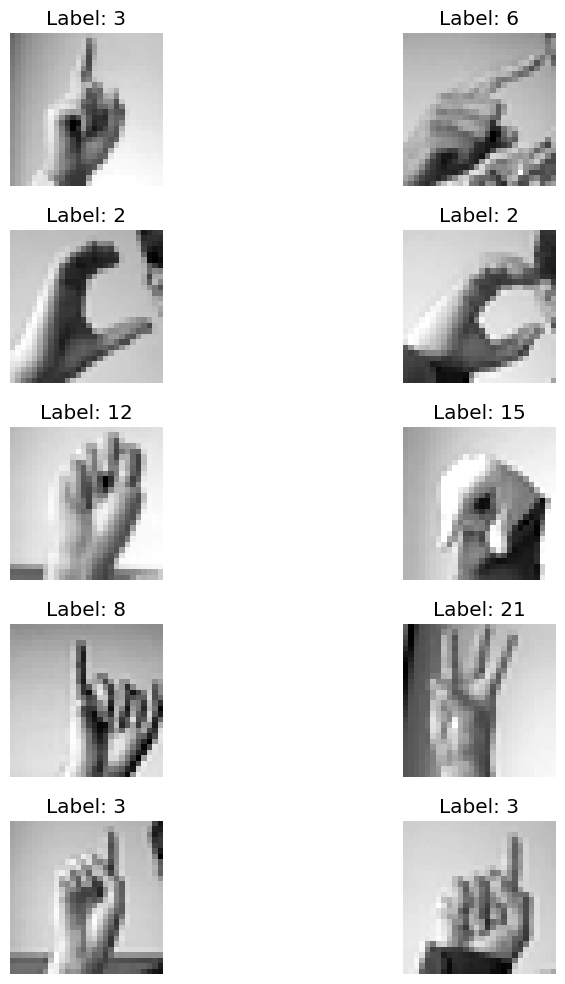

In [16]:
#displaying first 10 images
# Extract pixel values and labels
pixel_columns = train.columns[1:]
pixel_values = train[pixel_columns].values
labels = train['label'].values

# Display images
fig, axes = plt.subplots(5, 2, figsize=(8, 10))
fig.tight_layout()


for i in range(10):
    row = i // 2
    col = i % 2
    pixel_array = pixel_values[i].reshape(28, 28)
    # Display image on the corresponding subplot
    axes[row, col].imshow(pixel_array, cmap='gray')
    axes[row, col].set_title('Label: ' + str(labels[i]))
    axes[row, col].axis('off')

# Show the plot
plt.show()

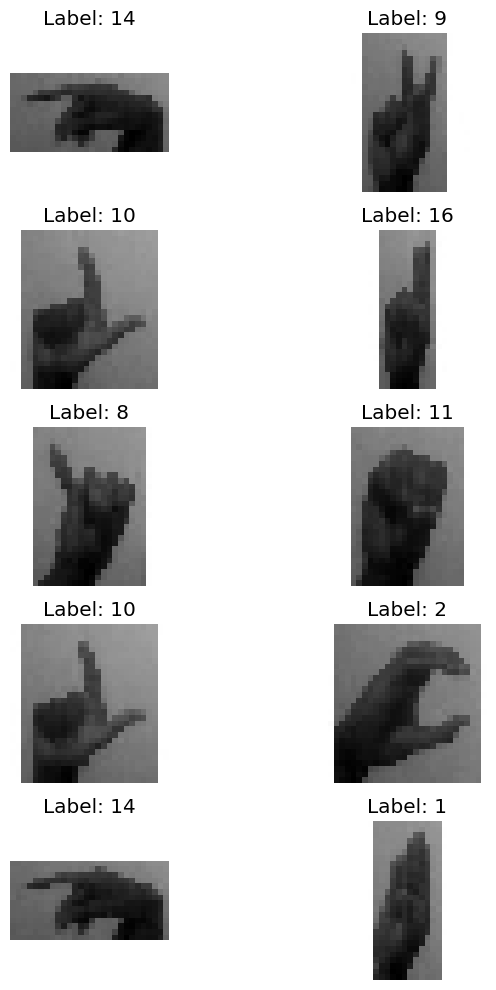

In [17]:
# Displaying the last 10 images
pixel_columns = train.columns[1:]
pixel_values = train[pixel_columns].values
labels = train['label'].values

# Get the last 10 images
last_10_images = pixel_values[-10:]
last_10_labels = labels[-10:]

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))

# Display images
for i, ax in enumerate(axes.flat):
    pixel_array = last_10_images[i].reshape(28, 28)
    ax.imshow(pixel_array, cmap='gray')
    ax.set_title('Label: ' + str(last_10_labels[i]))
    ax.axis('off')

plt.tight_layout()
plt.show()

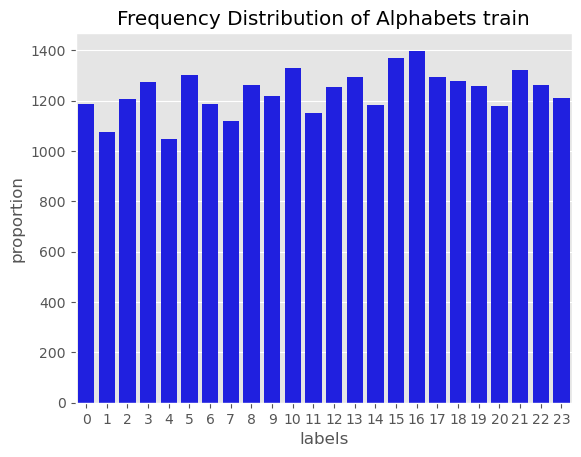

In [18]:
# Distribution of the labels column train dataset
def check_distribution(data, col, name):
  sns.countplot(data=data, x=col, color="blue")
  plt.xlabel('labels')
  plt.ylabel('proportion')
  plt.title(f"Frequency Distribution of Alphabets {(name)}")
  plt.show();

check_distribution(train, 'label', "train")

- In the analysis conducted, it was found that the label column exhibits a fairly distributed class distribution with no notable class imbalances. All classes display similar proportions, indicating a well-balanced dataset. This characteristic ensures that the model will have an equal opportunity to learn from and make accurate predictions across all classes.

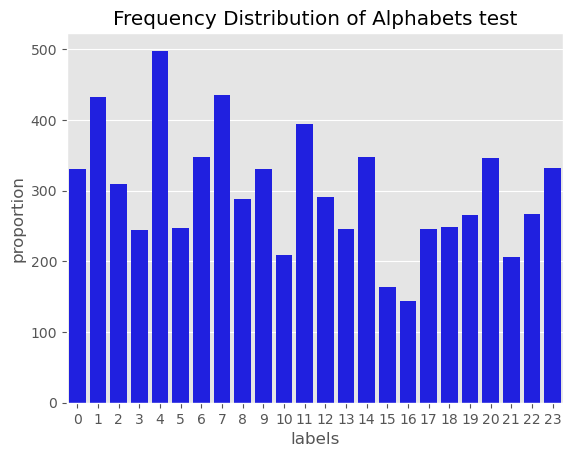

In [19]:
# Distribution of the labels column test dataset
check_distribution(test, 'label', "test")

## MODELLING

In [20]:
# Splitting the train and test datasets
train_X = train.iloc[:, 1:]
train_y = train.label

test_X = test.iloc[:, 1:]
test_y = test.label

In [21]:
#onehot encoding the train and test labels
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

In [22]:
# Normalizing our train and test data
train_X /= 255
test_X /= 255

In [23]:
train_X_reshaped = np.array(train_X).reshape(-1, 28, 28, 1)
test_X_reshaped = np.array(test_X).reshape(-1, 28, 28, 1)

In [24]:
#Preprocessing the images
def preprocess_images(images):
    preprocessed_images = []
    for image in images:
        image = skimage.filters.gaussian(image, sigma=1)
        image = skimage.exposure.equalize_hist(image)
        # blurred = cv2.GaussianBlur(image, (3,3), 0)
        preprocessed_images.append(image)
    return np.array(preprocessed_images).reshape(-1, 28, 28, 1)


train_X_reshaped = preprocess_images(train_X_reshaped)
test_X_reshaped = preprocess_images(test_X_reshaped)

c:\Users\Hp\anaconda3\envs\learn-env\lib\site-packages\skimage\_shared\utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


#### Baseline Model (Densely connected model)
The dense neural network architecture is chosen for its ability to capture complex patterns and relationships within the data.

In [25]:
# two layers baseline model
baseline_model = Sequential()
baseline_model.add(layers.Dense(64, activation="relu", input_shape=(784,)))
baseline_model.add(layers.Dense(32, activation="relu"))
baseline_model.add(layers.Dense(24, activation="softmax"))

#compiling our model
baseline_model.compile(loss="categorical_crossentropy",
                       optimizer="sgd",
                       metrics=["accuracy"])

#fitting the model
baseline_history = baseline_model.fit(train_X, train_y,
                                      epochs=100, batch_size=100,
                                      validation_split=0.2)

print("Baseline model test data accuracy: ")
baseline_model.evaluate(test_X, test_y)

Epoch 1/100
238/238 [==============================] - 9s 15ms/step - loss: 3.1210 - accuracy: 0.0944 - val_loss: 3.1142 - val_accuracy: 0.0895
Epoch 2/100
238/238 [==============================] - 3s 12ms/step - loss: 2.9909 - accuracy: 0.1709 - val_loss: 3.0469 - val_accuracy: 0.1032
Epoch 3/100
238/238 [==============================] - 3s 11ms/step - loss: 2.8172 - accuracy: 0.2147 - val_loss: 2.9608 - val_accuracy: 0.1678
Epoch 4/100
238/238 [==============================] - 3s 11ms/step - loss: 2.5692 - accuracy: 0.2977 - val_loss: 2.8490 - val_accuracy: 0.2129
Epoch 5/100
238/238 [==============================] - 3s 12ms/step - loss: 2.3021 - accuracy: 0.3713 - val_loss: 2.9314 - val_accuracy: 0.2696
Epoch 6/100
238/238 [==============================] - 3s 12ms/step - loss: 2.0681 - accuracy: 0.4184 - val_loss: 2.7750 - val_accuracy: 0.2929
Epoch 7/100
238/238 [==============================] - 3s 12ms/step - loss: 1.8665 - accuracy: 0.4670 - val_loss: 2.9466 - val_accuracy:

[1.3589887619018555, 0.7207194566726685]

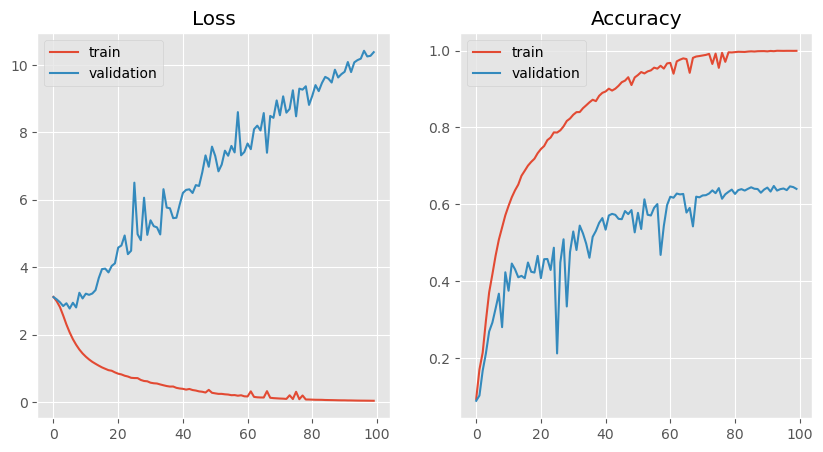

In [27]:
#Plotting the loss and accuracy of the test and validation datasets
def plot_loss_and_accuracy(results, final=False):

    if final:
        val_label="test"
    else:
        val_label="validation"

    # Extracting metrics from model fitting
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']

    # Setting up plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plotting loss info
    ax1.set_title("Loss")
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label="train")
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label=val_label)
    ax1.legend()

    # Plotting accuracy info
    ax2.set_title("Accuracy")
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax2, label="train")
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label=val_label)
    ax2.legend()

#baseline model loss and accuracy
plot_loss_and_accuracy(baseline_history)

In [44]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming train_X and test_X are DataFrames, convert them to NumPy arrays
train_X_np = train_X.to_numpy()
test_X_np = test_X.to_numpy()

# Reshape your data to (28, 28, 1)
train_X_reshaped = train_X_np.reshape(-1, 28, 28, 1)
test_X_reshaped = test_X_np.reshape(-1, 28, 28, 1)

# Create a Sequential model
cnn_model = Sequential()

# Add Convolutional layers
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

# Flatten the output from the Convolutional layers
cnn_model.add(Flatten())

# Add fully connected layers
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))  # Add dropout for regularization
cnn_model.add(Dense(24, activation='softmax'))  # Adjust the output layer to match your number of classes

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(train_X_reshaped, train_y, epochs=10, batch_size=100, validation_split=0.2)

# Evaluate the model on test data
test_loss, test_accuracy = cnn_model.evaluate(test_X_reshaped, test_y)
print(f'Test accuracy: {test_accuracy}')


Epoch 1/10
238/238 [==============================] - 49s 174ms/step - loss: 1.8821 - accuracy: 0.4326 - val_loss: 1.8910 - val_accuracy: 0.6247
Epoch 2/10
238/238 [==============================] - 40s 167ms/step - loss: 0.6099 - accuracy: 0.8016 - val_loss: 1.9146 - val_accuracy: 0.7029
Epoch 3/10
238/238 [==============================] - 40s 170ms/step - loss: 0.3182 - accuracy: 0.8976 - val_loss: 2.0967 - val_accuracy: 0.6955
Epoch 4/10
238/238 [==============================] - 40s 166ms/step - loss: 0.2013 - accuracy: 0.9372 - val_loss: 2.0868 - val_accuracy: 0.7107
Epoch 5/10
238/238 [==============================] - 40s 170ms/step - loss: 0.1348 - accuracy: 0.9592 - val_loss: 2.4701 - val_accuracy: 0.7019
Epoch 6/10
238/238 [==============================] - 40s 168ms/step - loss: 0.0988 - accuracy: 0.9693 - val_loss: 2.5984 - val_accuracy: 0.7211
Epoch 7/10
238/238 [==============================] - 40s 168ms/step - loss: 0.0805 - accuracy: 0.9760 - val_loss: 3.1685 - val_ac

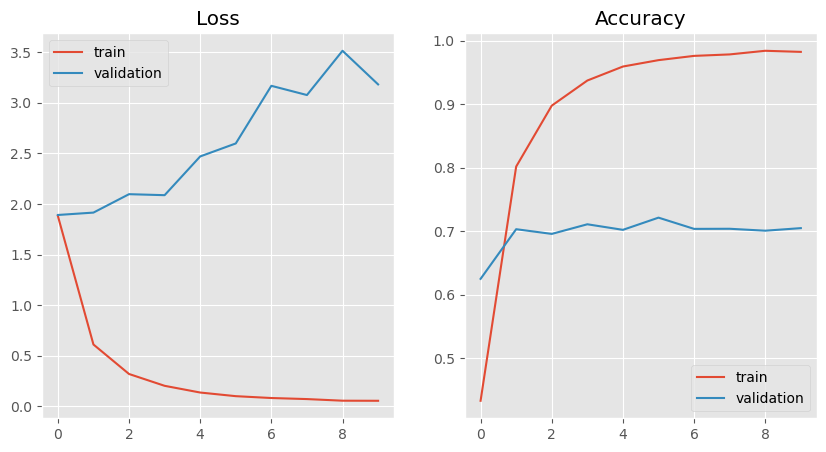

In [45]:
# Import the required libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Define the function to plot loss and accuracy
def plot_loss_and_accuracy(results, final=False):
    if final:
        val_label = "test"
    else:
        val_label = "validation"

    # Extracting metrics from model fitting
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']

    # Setting up plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plotting loss info
    ax1.set_title("Loss")
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label="train")
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label=val_label)
    ax1.legend()

    # Plotting accuracy info
    ax2.set_title("Accuracy")
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax2, label="train")
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label=val_label)
    ax2.legend()

# Assuming you have 'history' from your model training
plot_loss_and_accuracy(history)
plt.show()


In [47]:
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU

# Create a Sequential model
better_cnn_model = Sequential()

# Add Convolutional layers with Batch Normalization and Leaky ReLU activation
better_cnn_model.add(Conv2D(64, (3, 3), activation='linear', input_shape=(28, 28, 1)))
better_cnn_model.add(LeakyReLU(alpha=0.1))
better_cnn_model.add(MaxPooling2D((2, 2)))
better_cnn_model.add(BatchNormalization())

better_cnn_model.add(Conv2D(128, (3, 3), activation='linear'))
better_cnn_model.add(LeakyReLU(alpha=0.1))
better_cnn_model.add(MaxPooling2D((2, 2)))
better_cnn_model.add(BatchNormalization())

# Flatten the output from the Convolutional layers
better_cnn_model.add(Flatten())

# Add fully connected layers with Dropout
better_cnn_model.add(Dense(256, activation='linear'))
better_cnn_model.add(LeakyReLU(alpha=0.1))
better_cnn_model.add(Dropout(0.5))
better_cnn_model.add(Dense(128, activation='linear'))
better_cnn_model.add(LeakyReLU(alpha=0.1))

# Output layer with softmax activation
better_cnn_model.add(Dense(24, activation='softmax'))

# Compile the model
better_cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
better_history = better_cnn_model.fit(train_X_reshaped, train_y, epochs=10, batch_size=128, validation_split=0.2)

# Evaluate the model on test data
test_loss, test_accuracy = better_cnn_model.evaluate(test_X_reshaped, test_y)
print(f'Test accuracy: {test_accuracy}')


Epoch 1/10
186/186 [==============================] - 104s 531ms/step - loss: 0.4459 - accuracy: 0.8675 - val_loss: 4.7328 - val_accuracy: 0.0599
Epoch 2/10
186/186 [==============================] - 98s 526ms/step - loss: 0.0196 - accuracy: 0.9949 - val_loss: 4.8776 - val_accuracy: 0.2323
Epoch 3/10
186/186 [==============================] - 109s 585ms/step - loss: 0.0134 - accuracy: 0.9964 - val_loss: 2.3283 - val_accuracy: 0.5891
Epoch 4/10
186/186 [==============================] - 107s 572ms/step - loss: 0.0098 - accuracy: 0.9974 - val_loss: 3.3273 - val_accuracy: 0.6638
Epoch 5/10
186/186 [==============================] - 104s 559ms/step - loss: 0.0314 - accuracy: 0.9899 - val_loss: 5.3019 - val_accuracy: 0.6675
Epoch 6/10
186/186 [==============================] - 104s 558ms/step - loss: 0.0305 - accuracy: 0.9909 - val_loss: 4.9479 - val_accuracy: 0.6778
Epoch 7/10
186/186 [==============================] - 101s 540ms/step - loss: 0.0181 - accuracy: 0.9938 - val_loss: 5.0895 - 

Baseline Model Evaluation:
Loss: 1.3590, Accuracy: 0.7207

Baseline CNN Model Evaluation:
Loss: 0.2869, Accuracy: 0.9378

Better CNN Model Evaluation:
Loss: 0.9154, Accuracy: 0.8912


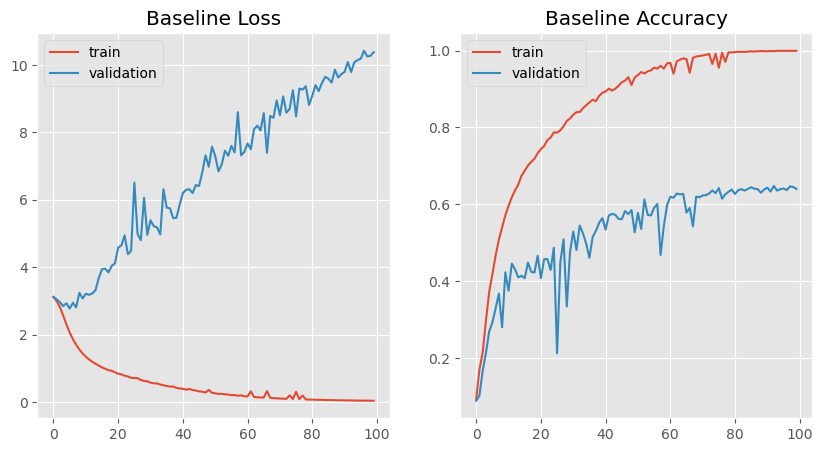

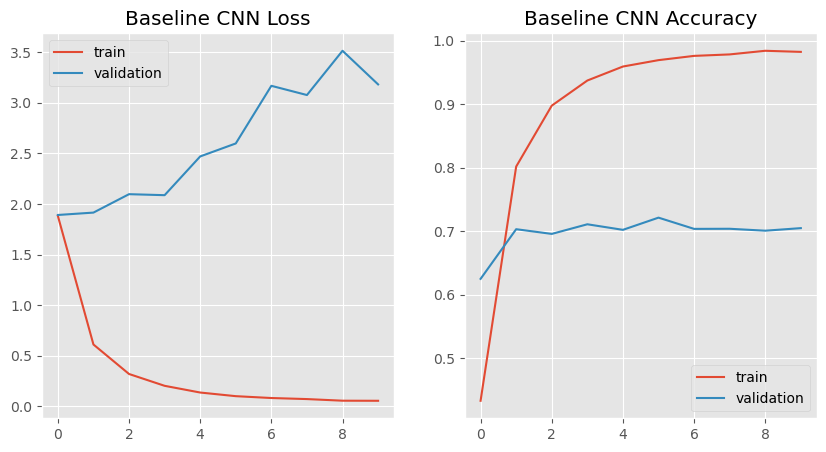

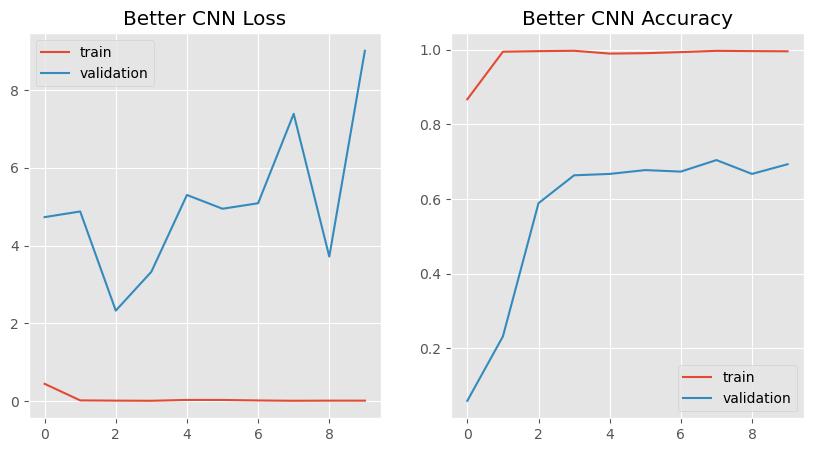

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the loss and accuracy of the test and validation datasets
def plot_loss_and_accuracy(results, model_name, final=False):
    if final:
        val_label = "test"
    else:
        val_label = "validation"

    # Extracting metrics from model fitting
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']

    # Setting up plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plotting loss info
    ax1.set_title(f"{model_name} Loss")
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label="train")
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label=val_label)
    ax1.legend()

    # Plotting accuracy info
    ax2.set_title(f"{model_name} Accuracy")
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax2, label="train")
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label=val_label)
    ax2.legend()

# Evaluate the models
baseline_eval = baseline_model.evaluate(test_X, test_y, verbose=0)
cnn_eval = cnn_model.evaluate(test_X_reshaped, test_y, verbose=0)
better_cnn_eval = better_cnn_model.evaluate(test_X_reshaped, test_y, verbose=0)

# Display the evaluation results
print("Baseline Model Evaluation:")
print(f"Loss: {baseline_eval[0]:.4f}, Accuracy: {baseline_eval[1]:.4f}")

print("\nBaseline CNN Model Evaluation:")
print(f"Loss: {cnn_eval[0]:.4f}, Accuracy: {cnn_eval[1]:.4f}")

print("\nBetter CNN Model Evaluation:")
print(f"Loss: {better_cnn_eval[0]:.4f}, Accuracy: {better_cnn_eval[1]:.4f}")

# Plot loss and accuracy for all models
plot_loss_and_accuracy(baseline_history, "Baseline")
plot_loss_and_accuracy(history, "Baseline CNN")
plot_loss_and_accuracy(better_history, "Better CNN")
plt.show()


In [51]:
#Making Predictions
predictions = cnn_model.predict(test_X_reshaped)
pred_labels = pd.Series([np.argmax(x) for x in predictions])

225/225 [==============================] - 8s 22ms/step


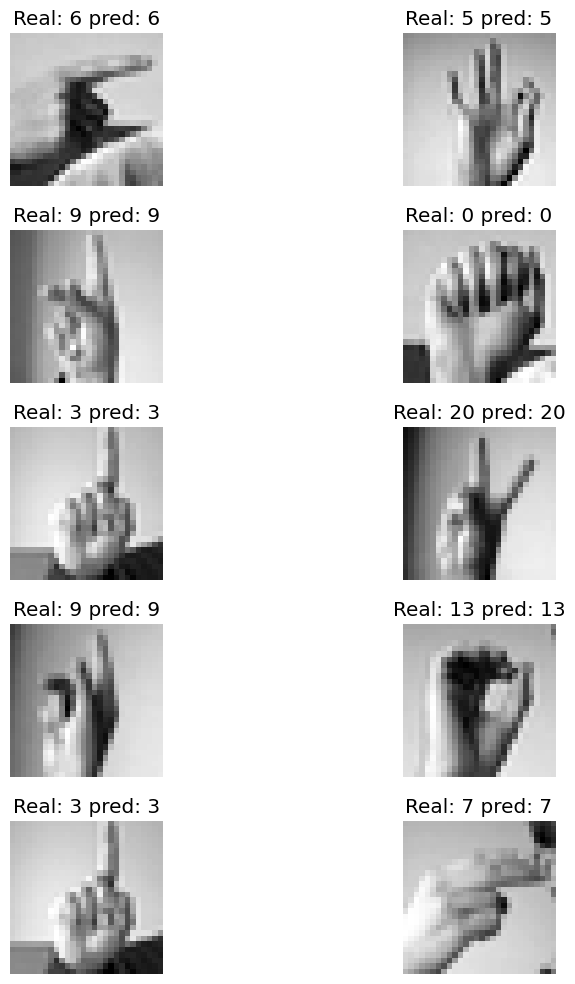

In [52]:
#displaying images
# Extract pixel values and labels
pixel_columns = test.columns[1:]
pixel_values = test[pixel_columns].values
labels = test['label'].values
pred_labels = pred_labels.values

# Display images
fig, axes = plt.subplots(5, 2, figsize=(8, 10))
fig.tight_layout()

# Display images
for i in range(10):
    row = i // 2
    col = i % 2
    pixel_array = pixel_values[i].reshape(28, 28)
    # Display image on the corresponding subplot
    axes[row, col].imshow(pixel_array, cmap='gray')
    axes[row, col].set_title(f"Real: {labels[i]} pred: {pred_labels[i]}")
    axes[row, col].axis('off')

# Show the plot
plt.show()

In [ ]:
#Saving the model
cnn_model.save(r"C:\Users\Hp\Desktop\finger spelling recognition\best_model.h5")